In [25]:
import numpy as np
from keras.models import Sequential 
from keras.layers import Dense 
from keras.layers import LSTM 
#from keras.layers.embeddings import Embedding 
from keras.layers import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout

2025-08-25 17:55:16.758203: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Get Data from alpaca

In [ ]:
from Alpaca_Connection import get_data_today
bars = get_data_today('mmm')
df= get_data_today('mmm')

In [21]:

#df = bars.df  # Convert to pandas DataFrame
df = df.reset_index()
# As you can see the simple import process allows for us to get an overall view of the daily market trade.  The date of the market instance is indexed making it easy to carry these variables without loosing the time coefficient.  For the aformentioned emphesis on simplicity we are going to focus on the market close price.  
df = df.rename(columns = {'open':'Open', 'high':'High', 'low':'Low', 'close':'Close', 'volume':'Volume', 'trade_count':'Trade Count'})


# It would appear that this may or may not be a great opportunity to buy.  It appears to have experianced a remarkable correction in February.  I hope to create a model that represents the best course of action.  

# ## Prepping the test data
# We are going to predict 38 days of open market into the furture giving us about 15% of the data.  We create a new variable to the dataframe called 'Prediction' where we look at the next 38 days close value and will use it as a response. 

df = df.reset_index()
future_days = 38
df['Prediction'] = df[['Close']].shift(-future_days)



In [23]:

X = np.array(df.drop(['Prediction','index', 'symbol', 'timestamp'], axis = 1))[:-future_days]
y = np.array(df['Prediction'])[:-future_days]
print("True Values")
print(y)


# Finally, we use the prediction column to create an array of the the future predictor days.  

# Get the last 'x' rows of the feature data set
x_future = df.drop(['index','Prediction', 'symbol', 'timestamp'],axis = 1)[:-future_days]
x_future = x_future.tail(future_days)
x_future = np.array(x_future)
# ## Splitting the data for performance testing
# In addition to the visual analysis, we are going to want to use our conventional Test/train split in order to train the data. We can use our conventional train_test_split dividing our 'live' close date with our prediction close date.   
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y)


True Values
[135.14 134.84 131.73 127.91 126.47 124.75 130.29 129.27 127.56 128.47
 127.22 125.85 126.52 133.92 133.07 134.34 133.   130.35 131.45 132.32
 129.79 130.17 128.19 127.84 127.32 128.42 130.32 132.95 132.48 133.53
 132.89 131.15 130.45 133.33 133.11 131.49 129.77 129.77 129.75 129.92
 129.47 128.05 125.53 127.13 129.28 128.98 130.36 131.18 130.18 129.13
 129.09 129.7  129.87 130.29 132.77 134.53 131.21 134.6  137.21 137.78
 139.18 141.03 146.89 149.12 149.63 149.43 151.52 151.4  151.54 154.4
 152.2  150.04 151.68 152.45 152.32 149.87 149.69 150.07 148.87 148.72
 148.62 148.99 150.2  149.08 144.98 145.48 146.54 147.43 150.52 155.12
 153.42 145.86 147.61 146.94 146.3  147.62 147.54 150.24 146.1  150.41
 153.21 150.92 153.21 151.27 150.36 153.15 153.5  152.68 148.44 144.84
 146.86 147.67 147.76 139.74 126.91 128.55 127.16 138.32 132.97 135.95
 136.01 135.26 130.46 130.21 126.09 136.33 136.06 138.88 137.32 137.93
 138.38 138.91 137.9  142.08 140.8  138.02 138.64 141.12 142.6  15

In [26]:
# ## LSTM network
# From background research I have done with predictive stock market modeling it appears that LSTM is the most common method used and I would not be a fool to explore it.  It manages to hold onto important information and 'forget' about useless information hence Long Term Short Memory.  
# ### Reprep the data
# It appeares that the LSTM Model is much more sensitive to the data structure than the other methods.  After running the same data the model was set on deliving a constant.  It appears that the data has to me scaled and properly wrangled before usage.  Hence we will have to reprepare the data.  

# As seen before we are going to look at the market close data and prepare all but 38 values to generate predictions.  

lstmData = df.filter(['Close'])
dataset = lstmData.values
training_data_len = len(dataset)-38


# Now as mentioned above, we have to scale the data.  Using the min max scaler we can turn all of our data into decimals (except for the min =0 and max =1).  We will save this data into our scaled_data datset.    

#Scale the data 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)


# Below you will see that we need to split the data again into x and y train and test.  Using a 60 day offset we can append them to an empty list using the prior 60 days to predict the next 60 days.  

#Re create Training Set 
lstm_train_data = scaled_data[0:training_data_len,:]
test_data = scaled_data[training_data_len - 60: ,:]

# Create the datasets
lstm_x_train = []
lstm_y_train = []
lstm_x_test = []
lstm_y_test = dataset[training_data_len:, :]

for i in range(60, len(lstm_train_data)):
    lstm_x_train.append(lstm_train_data[i-60:i])
    lstm_y_train.append(lstm_train_data[i,0])
    

for i in range(60, len(test_data)): 
    lstm_x_test.append(test_data[i-60:i, 0])    


# Now we have to convert the lists into numpy arrays so the data can be read.  Also, we have to reshape them into a format that the LSTM will understand.  

#Conver to numpy
lstm_x_train, lstm_y_train =   np.array(lstm_x_train), np.array(lstm_y_train)
lstm_x_test = np.array(lstm_x_test)
#Reshape the data
lstm_x_train = np.reshape(lstm_x_train, (lstm_x_train.shape[0], lstm_x_train.shape[1], 1))
lstm_x_test = np.reshape(lstm_x_test, (lstm_x_test.shape[0], lstm_x_test.shape[1], 1))


# Finally, we are back to building the models.  We are using 4 layers: The first two training layers then a dense layer and finally an output layer.  
model = Sequential() 
model.add(LSTM(50, return_sequences = True, input_shape=(lstm_x_train.shape[1],1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))
# Now that we have created the network, we can run the data through using the MSE method.  We will use 10 epocs because the loss is low, but futher iterations are not necessary.  Finally we have to undo the scaling to our predictions.  

#Compile the model 
model.compile(optimizer='adam', loss='mean_squared_error')
#Train the model 
model.fit(lstm_x_train, lstm_y_train, batch_size = 1, epochs = 10)  
LSTM_predictions = model.predict(lstm_x_test)
LSTM_predictions = scaler.inverse_transform(LSTM_predictions)
LSTM_predictions

Epoch 1/10


/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0443
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0154
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0131
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0174
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0138
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0168
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0110
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0087
Epoch 9/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0089
Epoch 10/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0124
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


array([[153.14299],
       [154.13379],
       [154.60254],
       [154.05539],
       [152.93729],
       [153.25577],
       [154.78601],
       [156.42429],
       [156.3295 ],
       [157.148  ],
       [156.79585],
       [156.9584 ],
       [157.87128],
       [155.04709],
       [153.06624],
       [151.36263],
       [150.4482 ],
       [149.42064],
       [150.0285 ],
       [151.09415],
       [151.67368],
       [149.27122],
       [149.01613],
       [146.78812],
       [147.12856],
       [148.86343],
       [150.46878],
       [151.81407],
       [153.28029],
       [155.07077],
       [157.32356],
       [159.6757 ],
       [158.49637],
       [154.91562],
       [153.08463],
       [153.1619 ],
       [153.70879],
       [153.89986]], dtype=float32)

In [27]:
# Because of the necessary transformations that were done to the model, we cannot use the same function as above. However we can poach  a massive chunk from above and paste it into our model.  

t = lstmData[:training_data_len]
v = lstmData[training_data_len:]
v['Predictions'] = LSTM_predictions



#mean_squared_error(X_test[:38],LSTM_predictions)

print("Actual Values:")
X_test[0][2]
#df.head()
X_test[0]

    
[row[2] for row in X_test]


Actual Values:


/var/folders/3r/pc8xl1ls1y35f9xzjdj87z0c0000gn/T/ipykernel_2335/2276115397.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v['Predictions'] = LSTM_predictions


[139.765,
 150.0,
 137.05,
 144.49,
 129.92,
 153.47,
 133.78,
 143.04,
 133.87,
 127.738,
 132.15,
 134.43,
 139.31,
 142.15,
 151.11,
 130.35,
 149.18,
 132.72,
 148.36,
 149.86,
 152.46,
 129.45,
 150.1,
 155.5,
 137.34,
 154.025,
 151.63,
 134.99,
 130.6,
 131.25,
 153.28,
 134.4799,
 135.02,
 132.62,
 133.18,
 137.22,
 130.6699,
 150.36,
 152.78,
 150.46,
 128.52,
 134.68,
 147.72,
 129.84,
 141.34,
 131.18,
 133.85,
 151.0399,
 152.76,
 139.5,
 130.05,
 148.85,
 145.39]

## Buy/Sell Strategy: 
If the next prediction is less than current actual: Sell
If the next prediction is more than the current actual: Buy
Create a dataframe of the values with the buy/sell signal.  
Then create look into backtesting the signal.  

In [37]:
buy_sell = pd.DataFrame({"Actuals": [row[2] for row in X_test][15:]})#, "Predictions":LSTM_predictions })
buy_sell["Predictions"] = LSTM_predictions
buy_sell["Predictions Offset"] = pd.DataFrame(LSTM_predictions).shift(1)
buy_sell["signal"] = np.where(buy_sell["Actuals"]> buy_sell["Predictions Offset"], 1, -1 )
buy_sell["returns"] = np.log(buy_sell["Actuals"]/ buy_sell["Actuals"].shift(1))
buy_sell["strategy"] = buy_sell["returns"]*buy_sell["signal"]
buy_sell

,Actuals,Predictions,Predictions Offset,signal,returns,strategy
0,130.3500,153.142990,NaN,-1,NaN,NaN
1,149.1800,154.133789,153.142990,-1,0.134930,-0.134930
2,132.7200,154.602539,154.133789,-1,-0.116912,0.116912
3,148.3600,154.055389,154.602539,-1,0.111400,-0.111400
4,149.8600,152.937286,154.055389,-1,0.010060,-0.010060
5,152.4600,153.255768,152.937286,-1,0.017201,-0.017201
6,129.4500,154.786011,153.255768,-1,-0.163608,0.163608
7,150.1000,156.424286,154.786011,-1,0.148007,-0.148007
8,155.5000,156.329498,156.424286,-1,0.035344,-0.035344
9,137.3400,157.147995,156.329498,-1,-0.124186,0.124186


In [40]:
buy_sell[["returns", "strategy"]].sum()

returns     0.109197
strategy    0.483174
dtype: float64

In [42]:
buy_sell[["returns", "strategy"]].sum().apply(np.exp)

returns     1.115382
strategy    1.621212
dtype: float64

<AxesSubplot:>

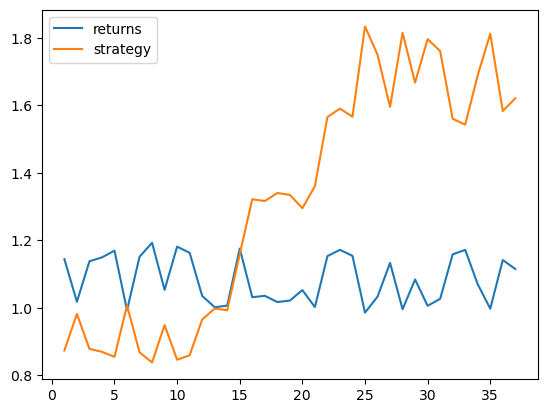

In [44]:
buy_sell[["returns", "strategy"]].cumsum().apply(np.exp).plot()

## Average period return risk statistics for both the stock and strategy. 
(32 = # of cycles; 252 = annual period)

Calculates the period mean return in both log and regular price
 
Conclusion(8/30): Equal risk, much higher reward

In [52]:
buy_sell[['returns', 'strategy']].mean()*32

returns     0.09444
strategy    0.41788
dtype: float64

In [51]:
np.exp(buy_sell[['returns', 'strategy']].mean()*32)-1

returns     0.099044
strategy    0.518739
dtype: float64

Calculates the period standard deviation of both log and regular spaces

In [53]:
buy_sell[['returns', 'strategy']].std()*32**.5

returns     0.529001
strategy    0.523946
dtype: float64

In [54]:
(buy_sell[['returns', 'strategy']].apply(np.exp)-1).std()*32**.5

returns     0.531533
strategy    0.532305
dtype: float64

## Evaluate the drawdaown with the cummax/cumret

Defines a new column, cumret, with a gross performance over time

In [55]:
## Evaluate the drawdaown with the cummax/cumret 
buy_sell['cumret'] =buy_sell['strategy'].cumsum().apply(np.exp)

Defines yet another column with a running maximum value of the gross performance

In [56]:
buy_sell['cummax'] = buy_sell['cumret'].cummax()

<AxesSubplot:>

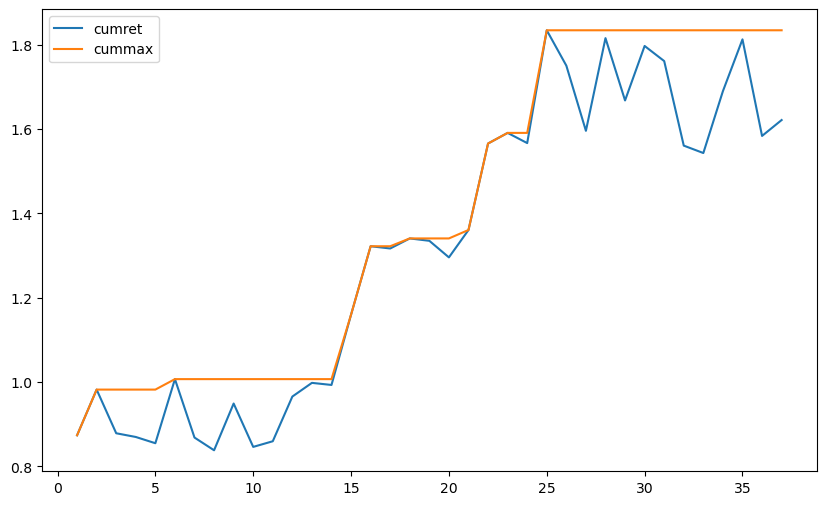

In [58]:
buy_sell[['cumret', 'cummax']].dropna().plot(figsize= (10,6))

The max drawdown is calcualated as the difference between the two columns

In [60]:
drawdown = buy_sell['cummax'] - buy_sell['cumret']
drawdown.max()

0.2910225496266545